# Naive Bayes Model

### Import required modules

In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans
import pandas as pd
from scipy import ndimage

### Batch Processing Function

In [14]:
def batch_process_images(image_dataset, process_func):
    """
    Batch process images from a dictionary of images.
    
    Args:
    - image_dataset (dict): A dictionary where keys are labels and values are lists of images.
    - process_func (function): Function to apply to each image.
    
    Returns:
    - dict: A dictionary where keys are labels and values are lists of processed images.
    """
    processed_images = {}
    
    # Iterate through each label and its images
    for label, images in image_dataset.items():
        processed_images[label] = []
        
        # Process each image in the label
        for img in tqdm(images, desc=f"Processing {label}"):
            processed_img = process_func(img)
            processed_images[label].append(processed_img)
    
    return processed_images

### Read Images

In [15]:
def read_image_dataset(dataset_path):
    """
    Read images from a dataset directory with subfolders.
    
    Args:
    - dataset_path (str): Path to the dataset folder containing subfolders of images.
    
    Returns:
    - dict: A dictionary where keys are labels (folder names) and values are lists of images.
    """
    image_dataset = {}
    
    # Iterate through each subfolder (label) in the dataset
    for label in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label)
        if not os.path.isdir(label_path):
            continue
        
        image_dataset[label] = []
        
        # Iterate through each image in the subfolder
        for img_name in tqdm(os.listdir(label_path), desc=f"Reading {label}"):
            img_path = os.path.join(label_path, img_name)
            
            # Read the image
            img = cv2.imread(img_path)
            if img is not None:
                image_dataset[label].append(img)
    
    return image_dataset

### Saving Images Function

In [16]:
def save_processed_images(processed_images, output_path):
    """
    Save processed images to the specified output path.
    
    Args:
    - processed_images (dict): Dictionary of processed images as returned by batch_process_images.
    - output_path (str): Path to save processed images.
    """
    for label, images in processed_images.items():
        label_output_path = os.path.join(output_path, label)
        os.makedirs(label_output_path, exist_ok=True)
        
        for i, img in enumerate(images):
            img_name = f"{label}_{i}.png"  # You can modify this naming convention
            img_path = os.path.join(label_output_path, img_name)
            cv2.imwrite(img_path, img)
        
        print(f"Saved {len(images)} images for label: {label}")

# Save images function 2

In [17]:
import os
import cv2
import numpy as np

def save_processed_images2(processed_images, output_path):
    """
    Save processed binary images to the specified output path.
    
    Args:
    - processed_images (dict): Dictionary of processed binary images as returned by batch_process_images.
    - output_path (str): Path to save processed images.
    """
    for label, images in processed_images.items():
        label_output_path = os.path.join(output_path, label)
        os.makedirs(label_output_path, exist_ok=True)
        
        for i, img in enumerate(images):
            # Convert binary image (0/1) to proper image format (0/255)
            img_to_save = (img * 255).astype(np.uint8)
            
            # If the image is 2D (single channel), convert to 3 channels
            if len(img_to_save.shape) == 2:
                img_to_save = cv2.cvtColor(img_to_save, cv2.COLOR_GRAY2BGR)
            
            img_name = f"{label}_{i}.png"
            img_path = os.path.join(label_output_path, img_name)
            
            # Save the image
            success = cv2.imwrite(img_path, img_to_save)
            if not success:
                print(f"Warning: Failed to save image {img_name}")
        
        print(f"Saved {len(images)} images for label: {label}")

### Function for preprocessing step

In [18]:
def preprocess_image(img, target_size=(256, 256)):
    # Resize the image
    resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    
    return resized_img

Processing daun_menguning: 100%|██████████| 45/45 [00:00<00:00, 4998.51it/s]


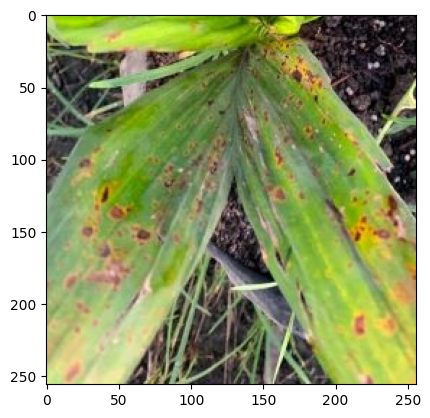

In [19]:
# Example usage
dataset_path = 'C:\\Users\\alvin\\Documents\\KULIAH\\MATA_KULIAH\\SEMESTER_6\\Machine_Learning\\sawit_2\\dataset_hasil_cropping'
dataset_images = read_image_dataset(dataset_path)
processed_images = batch_process_images(dataset_images, preprocess_image)

# Display the processed image (optional)
plt.imshow(cv2.cvtColor(processed_images['bercak_daun'][0], cv2.COLOR_BGR2RGB))
plt.axis('on')
plt.show()

In [20]:
save_processed_images(processed_images, 'C:\\Users\\alvin\\Documents\\KULIAH\\MATA_KULIAH\\SEMESTER_6\\Machine_Learning\\sawit_2\\preprocessed_images')

Saved 45 images for label: bercak_daun
Saved 45 images for label: daun_berkerut
Saved 45 images for label: daun_berputar
Saved 45 images for label: daun_menggulung
Saved 45 images for label: daun_menguning


### Conver to LAB Function

In [21]:
def convert_to_lab(image):
    """
    Convert BGR image to L*a*b color space.
    
    Args:
    - image (numpy.ndarray): Input image in BGR format.
    
    Returns:
    - numpy.ndarray: Image in L*a*b color space.
    """
    return cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

In [22]:
# Example usage
lab_images = batch_process_images(processed_images, convert_to_lab)

Processing daun_menguning: 100%|██████████| 45/45 [00:00<00:00, 2499.52it/s]


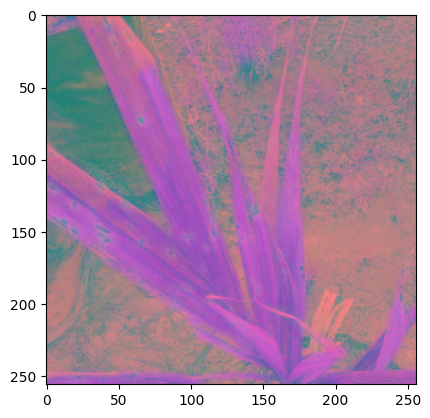

In [23]:
# Display the processed image (optional)
plt.imshow(lab_images['bercak_daun'][3])
plt.axis('on')
plt.show()

In [15]:
save_processed_images(lab_images, 'C:\\Users\\alvin\\Documents\\KULIAH\\MATA_KULIAH\\SEMESTER_6\\Machine_Learning\\sawit_2\\lab_images')

Saved 45 images for label: bercak_daun
Saved 45 images for label: daun_berkerut
Saved 45 images for label: daun_berputar
Saved 45 images for label: daun_menggulung
Saved 45 images for label: daun_menguning


### K-Means Clustering Function

In [24]:
def kmeans_segment(image, n_clusters=2):
    """
    Perform K-means segmentation on an input LAB color space image.
    
    Args:
    image (numpy.ndarray): Input image in LAB color space as a numpy array.
    n_clusters (int): Number of clusters (default is 2 for binary segmentation).
    
    Returns:
    numpy.ndarray: Binary segmented image.
    """
    # Normalize the LAB values for better clustering
    # L channel: [0, 100] -> [0, 1]
    # a,b channels: [-127, 127] -> [0, 1]
    normalized_image = np.zeros_like(image, dtype=np.float32)
    normalized_image[:,:,0] = image[:,:,0] / 100.0
    normalized_image[:,:,1] = (image[:,:,1] + 127) / 254.0
    normalized_image[:,:,2] = (image[:,:,2] + 127) / 254.0
    
    # Reshape the image to a 2D array of pixels
    pixels = normalized_image.reshape((-1, 3))
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(pixels)
    
    # Get the labels and reshape them to the original image shape
    labels = kmeans.labels_.reshape(image.shape[:2])
    
    # Create binary image (0 for background, 1 for foreground)
    # For LAB space, we look at the L (luminance) value of the cluster centers
    # Convert cluster centers back to original LAB scale for L channel
    cluster_l_values = kmeans.cluster_centers_[:, 0] * 100.0
    foreground_label = np.argmax(cluster_l_values)
    binary_image = (labels == foreground_label).astype(np.uint8)
    
    return binary_image

In [25]:
# Example usage
kmeans_images = batch_process_images(lab_images, kmeans_segment)

Processing daun_menguning: 100%|██████████| 45/45 [00:00<00:00, 47.91it/s]


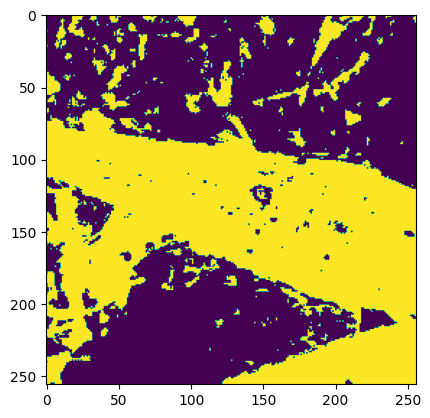

In [26]:
plt.imshow(kmeans_images['bercak_daun'][41])
plt.axis('on')
plt.show()

In [28]:
save_processed_images2(kmeans_images, 'C:\\Users\\alvin\\Documents\\KULIAH\\MATA_KULIAH\\SEMESTER_6\\Machine_Learning\\sawit_2\\kmeans_images')

Saved 45 images for label: bercak_daun
Saved 45 images for label: daun_berkerut
Saved 45 images for label: daun_berputar
Saved 45 images for label: daun_menggulung
Saved 45 images for label: daun_menguning


### Filling Holes Function

In [45]:
def imfill(image, method='holes'):
    """
    Fill holes in binary images using flood fill algorithm.
    Similar to MATLAB's imfill function with 'holes' method.
    
    Args:
    image (numpy.ndarray): Binary input image
    method (str): Currently only supports 'holes' method
    
    Returns:
    numpy.ndarray: Binary image with holes filled
    
    Raises:
    ValueError: If method is not 'holes' or if input image is not 2D
    TypeError: If input image is not a numpy array
    """
    # Input validation
    if not isinstance(image, np.ndarray):
        raise TypeError("Input image must be a numpy array")
        
    if image.ndim != 2:
        raise ValueError("Input image must be 2D")
        
    if method != 'holes':
        raise ValueError("This function only supports the 'holes' method")
    
    # Ensure the image is binary
    binary_image = (image > 0).astype(bool)
    
    # Create a structuring element for flood filling
    struct = ndimage.generate_binary_structure(2, 1)  # explicitly use 2 for 2D
    
    # Create a starting mask for flood fill
    # Add border of zeros around the image
    mask = np.zeros(np.array(binary_image.shape) + 2, dtype=bool)
    mask[1:-1, 1:-1] = binary_image
    
    # Flood fill from the border
    filled = ndimage.binary_fill_holes(mask, structure=struct)
    
    # Remove the border
    filled = filled[1:-1, 1:-1]
    
    # Return the same type as input
    return filled.astype(image.dtype)

In [46]:
# Example usage
filled_holes_images = batch_process_images(kmeans_images, imfill)

Processing daun_menguning: 100%|██████████| 45/45 [00:00<00:00, 375.59it/s]


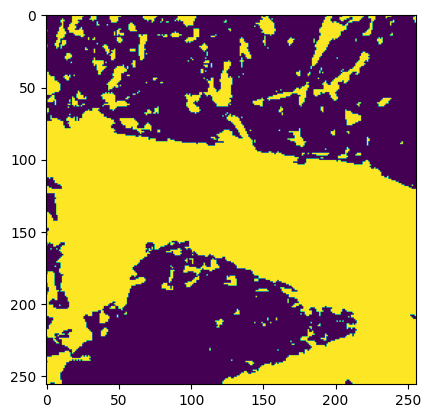

In [47]:
plt.imshow(filled_holes_images['bercak_daun'][41])
plt.axis('on')
plt.show()

In [48]:
save_processed_images2(filled_holes_images, 'C:\\Users\\alvin\\Documents\\KULIAH\\MATA_KULIAH\\SEMESTER_6\\Machine_Learning\\sawit_2\\kmeans_images')

Saved 45 images for label: bercak_daun
Saved 45 images for label: daun_berkerut
Saved 45 images for label: daun_berputar
Saved 45 images for label: daun_menggulung
Saved 45 images for label: daun_menguning


### Apply Mask Function

In [49]:
def batch_process_images_with_masks(image_dataset, mask_dataset):
    """
    Batch process images from dictionaries of images and masks, applying masks using cv2.bitwise_and.
    
    Args:
    - image_dataset (dict): A dictionary where keys are labels and values are lists of images.
    - mask_dataset (dict): A dictionary where keys are labels and values are lists of masks.
    
    Returns:
    - dict: A dictionary where keys are labels and values are lists of processed images.
    """
    processed_images = {}
    
    # Ensure image_dataset and mask_dataset have the same labels
    assert set(image_dataset.keys()) == set(mask_dataset.keys()), "Image and mask datasets must have the same labels"
    
    # Iterate through each label and its images/masks
    for label in image_dataset.keys():
        processed_images[label] = []
        
        # Ensure the number of images and masks match for each label
        assert len(image_dataset[label]) == len(mask_dataset[label]), f"Number of images and masks must match for label {label}"
        
        # Process each image-mask pair in the label
        for img, mask in tqdm(zip(image_dataset[label], mask_dataset[label]), desc=f"Processing {label}", total=len(image_dataset[label])):
            # Ensure img and mask have the same shape (height and width)
            assert img.shape[:2] == mask.shape[:2], f"Image and mask shapes must match for label {label}"
            
            # Apply mask using cv2.bitwise_and
            processed_img = cv2.bitwise_and(img, img, mask=mask)
            processed_images[label].append(processed_img)
    
    return processed_images

In [50]:
# Example usage
cut_images = batch_process_images_with_masks(processed_images, filled_holes_images)

Processing daun_menguning: 100%|██████████| 45/45 [00:00<00:00, 984.55it/s]


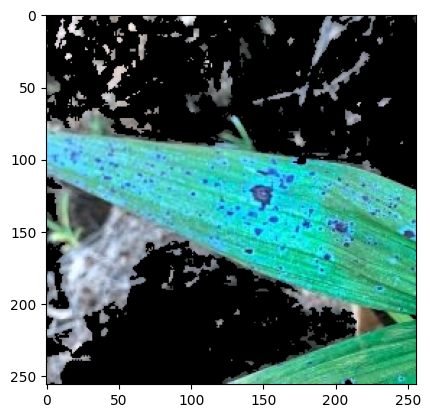

In [51]:
plt.imshow(cut_images['bercak_daun'][41])
plt.axis('on')
plt.show()

In [52]:
save_processed_images(cut_images, 'C:\\Users\\alvin\\Documents\\KULIAH\\MATA_KULIAH\\SEMESTER_6\\Machine_Learning\\sawit_2\\cut_images')

Saved 45 images for label: bercak_daun
Saved 45 images for label: daun_berkerut
Saved 45 images for label: daun_berputar
Saved 45 images for label: daun_menggulung
Saved 45 images for label: daun_menguning


In [53]:
def extract_rgb(image):
    """
    Extract normalized RGB values from image.
    Args:
        image: numpy array of shape (height, width, 3) representing RGB image
    Returns:
        tuple of normalized (r, g, b) values
    """
    # Convert to double precision
    image = image.astype(np.float64)
    
    # Calculate mean of non-zero values for each channel
    r_mean = np.mean(image[:,:,0][image[:,:,0] != 0])
    g_mean = np.mean(image[:,:,1][image[:,:,1] != 0])
    b_mean = np.mean(image[:,:,2][image[:,:,2] != 0])
    
    # Normalize
    total = r_mean + g_mean + b_mean
    return (r_mean/total, g_mean/total, b_mean/total)

def extract_texture(image):
    """
    Extract GLCM texture features from grayscale image.
    Args:
        image: numpy array of shape (height, width) representing grayscale image
    Returns:
        tuple of (contrast, correlation, energy, homogeneity)
    """
    # Convert image to uint8 and scale to 0-255
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    
    # Reduce to 8 gray levels as MATLAB does by default
    image = (image / 32).astype(np.uint8)
    
    # Calculate GLCM with same offsets as MATLAB
    offsets = [(0, 1), (-1, 1), (-1, 0), (-1, -1)]
    glcm = graycomatrix(image, distances=[1], angles=[0, 45, 90, 135], 
                       levels=8, symmetric=True, normed=True)
    
    # Calculate properties and average over all directions
    contrast = np.mean(graycoprops(glcm, 'contrast'))
    correlation = np.mean(graycoprops(glcm, 'correlation'))
    energy = np.mean(graycoprops(glcm, 'energy'))
    homogeneity = np.mean(graycoprops(glcm, 'homogeneity'))
    
    return contrast, correlation, energy, homogeneity

def process_leaf_images(image_dict):
    """
    Process dictionary of leaf disease images and create feature table.
    Args:
        image_dict: dictionary where keys are disease labels and values are lists of RGB image arrays
    Returns:
        pandas DataFrame with RGB and GLCM features plus labels
    """
    # Lists to store features and labels
    features = []
    labels = []
    
    # Process each label and its images
    for label, images in image_dict.items():
        for img in images:
            # Extract RGB features
            r, g, b = extract_rgb(img)
            
            # Convert to grayscale for GLCM
            gray_img = np.mean(img, axis=2)
            
            # Extract texture features
            contrast, correlation, energy, homogeneity = extract_texture(gray_img)
            
            # Append features and label
            features.append([r, g, b, contrast, correlation, energy, homogeneity])
            labels.append(label)
    
    # Create DataFrame
    columns = ['R', 'G', 'B', 'Contrast', 'Correlation', 'Energy', 'Homogeneity']
    df = pd.DataFrame(features, columns=columns)
    df['Label'] = labels
    
    return df

In [54]:
feature_table = process_leaf_images(cut_images)

In [56]:
feature_table

,R,G,B,Contrast,Correlation,Energy,Homogeneity,Label
0,0.228847,0.404755,0.366397,8.426453,0.285569,0.194707,0.448917,bercak_daun
1,0.195562,0.431658,0.372780,8.196314,0.346122,0.244647,0.478797,bercak_daun
2,0.264877,0.389382,0.345741,7.823209,0.380662,0.300049,0.508344,bercak_daun
3,0.237302,0.406529,0.356169,7.193510,0.418119,0.303183,0.536755,bercak_daun
4,0.274699,0.375027,0.350274,5.709409,0.517829,0.447824,0.631616,bercak_daun
...,...,...,...,...,...,...,...,...
220,0.311873,0.331786,0.356341,1.774545,0.731874,0.809749,0.903017,daun_menguning
221,0.269059,0.373134,0.357807,5.496999,0.530312,0.387866,0.646789,daun_menguning
222,0.241366,0.392187,0.366447,4.721095,0.585171,0.541153,0.703436,daun_menguning
223,0.172193,0.433481,0.394325,5.313919,0.581686,0.438949,0.664250,daun_menguning


In [57]:
feature_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   R            225 non-null    float64
 1   G            225 non-null    float64
 2   B            225 non-null    float64
 3   Contrast     225 non-null    float64
 4   Correlation  225 non-null    float64
 5   Energy       225 non-null    float64
 6   Homogeneity  225 non-null    float64
 7   Label        225 non-null    object 
dtypes: float64(7), object(1)
memory usage: 14.2+ KB


In [55]:
feature_table[['R', 'G', 'B']].head()

,R,G,B
0,0.228847,0.404755,0.366397
1,0.195562,0.431658,0.372780
2,0.264877,0.389382,0.345741
3,0.237302,0.406529,0.356169
4,0.274699,0.375027,0.350274


In [58]:
grouped_features = feature_table.groupby('Label').agg({
    'R': 'mean',
    'G': 'mean',
    'B': 'mean',
    'Contrast': 'mean',
    'Correlation': 'mean',
    'Energy': 'mean',
    'Homogeneity': 'mean'
}).round(2)


In [59]:
grouped_features

,R,G,B,Contrast,Correlation,Energy,Homogeneity
Label,,,,,,,
bercak_daun,0.24,0.39,0.36,6.78,0.44,0.36,0.57
daun_berkerut,0.27,0.38,0.34,5.73,0.51,0.40,0.63
daun_berputar,0.28,0.37,0.34,6.16,0.48,0.40,0.61
daun_menggulung,0.27,0.38,0.35,5.47,0.52,0.43,0.65
daun_menguning,0.23,0.40,0.37,5.28,0.54,0.47,0.67


C:\Users\alvin\AppData\Local\Temp\ipykernel_32388\2906269628.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i - width, grouped_features['R'][i], f"{grouped_features['R'][i]:.1f}", ha='center', va='bottom')
C:\Users\alvin\AppData\Local\Temp\ipykernel_32388\2906269628.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, grouped_features['G'][i], f"{grouped_features['G'][i]:.1f}", ha='center', va='bottom')
C:\Users\alvin\AppData\Local\Temp\ipykernel_32388\2906269628.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always 

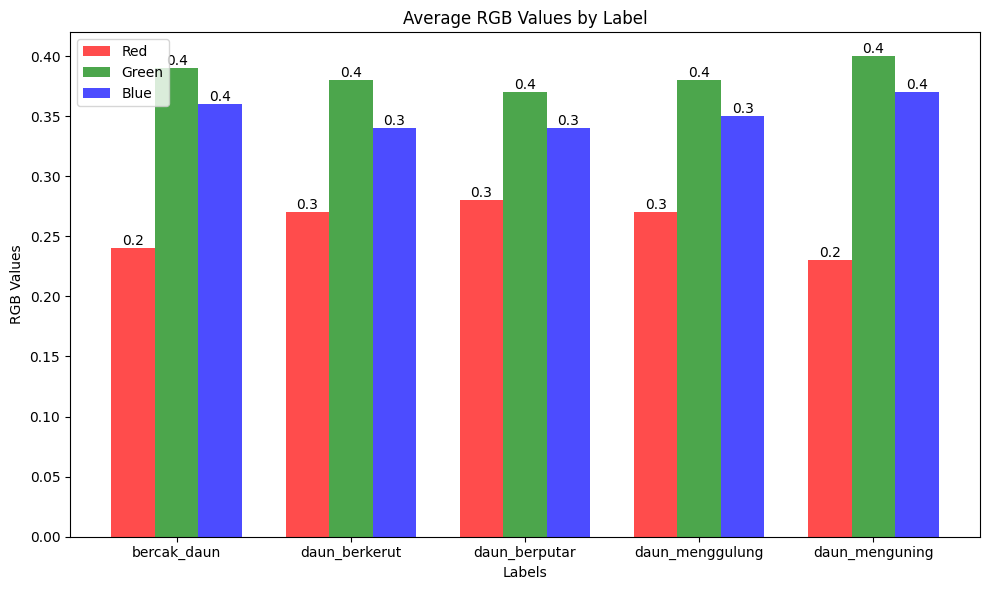

In [71]:
# Plotting
plt.figure(figsize=(10, 6))

# Set the positions for the bars
labels = grouped_features.index
x = range(len(labels))
width = 0.25  # Width of the bars

# Create bars for each color channel
plt.bar([i - width for i in x], grouped_features['R'], width, label='Red', color='red', alpha=0.7)
plt.bar(x, grouped_features['G'], width, label='Green', color='green', alpha=0.7)
plt.bar([i + width for i in x], grouped_features['B'], width, label='Blue', color='blue', alpha=0.7)

# Customize the plot
plt.xlabel('Labels')
plt.ylabel('RGB Values')
plt.title('Average RGB Values by Label')
plt.xticks(x, labels)
plt.legend()

# Add value labels on top of each bar
for i in x:
    plt.text(i - width, grouped_features['R'][i], f"{grouped_features['R'][i]:.1f}", ha='center', va='bottom')
    plt.text(i, grouped_features['G'][i], f"{grouped_features['G'][i]:.1f}", ha='center', va='bottom')
    plt.text(i + width, grouped_features['B'][i], f"{grouped_features['B'][i]:.1f}", ha='center', va='bottom')

# Adjust layout and display
plt.tight_layout()
plt.savefig('rgb_values_by_label.png')
plt.show()

<Figure size 640x480 with 0 Axes>

In [230]:
def train_leaf_classifier(feature_df, test_size=0.2, random_state=42):
    """
    Train a Gaussian Naive Bayes classifier on leaf disease features.
    
    Args:
        feature_df: pandas DataFrame output from process_leaf_images()
        test_size: proportion of data to use for testing (default: 0.2)
        random_state: random seed for reproducibility (default: 42)
    
    Returns:
        dict containing:
            - 'model': trained GaussianNB model
            - 'scaler': fitted StandardScaler
            - 'accuracy': test set accuracy
            - 'classification_report': detailed classification metrics
            - 'confusion_matrix': confusion matrix
            - 'feature_importance': feature importance scores
    """
    # Separate features and labels
    X = feature_df.drop('Label', axis=1)
    y = feature_df['Label']
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train the model
    model = GaussianNB()
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate feature importance using variance of each feature for each class
    class_feature_var = []
    for class_idx in range(len(model.classes_)):
        class_var = np.var(X_train_scaled[y_train == model.classes_[class_idx]], axis=0)
        class_feature_var.append(class_var)
    
    # Average variance across classes for overall feature importance
    feature_importance = np.mean(class_feature_var, axis=0)
    feature_importance = dict(zip(X.columns, feature_importance))
    
    # Sort feature importance
    feature_importance = dict(sorted(feature_importance.items(), 
                                   key=lambda x: x[1], 
                                   reverse=True))
    
    return {
        'model': model,
        'scaler': scaler,
        'accuracy': model.score(X_test_scaled, y_test),
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'feature_importance': feature_importance
    }

In [233]:
model_results = train_leaf_classifier(feature_table)

In [235]:
# Print the results
print(f"Model accuracy: {model_results['accuracy']:.2f}")
print("\nClassification Report:")
print(model_results['classification_report'])
print("\nFeature Importance:")
for feature, importance in model_results['feature_importance'].items():
    print(f"{feature}: {importance:.3f}")


Model accuracy: 0.40

Classification Report:
                 precision    recall  f1-score   support

    bercak_daun       0.33      0.33      0.33         9
  daun_berkerut       0.33      0.22      0.27         9
  daun_berputar       0.38      0.67      0.48         9
daun_menggulung       0.20      0.11      0.14         9
 daun_menguning       0.67      0.67      0.67         9

       accuracy                           0.40        45
      macro avg       0.38      0.40      0.38        45
   weighted avg       0.38      0.40      0.38        45


Feature Importance:
G: 0.904
Energy: 0.869
Homogeneity: 0.831
Contrast: 0.825
Correlation: 0.817
R: 0.763
B: 0.655
